In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

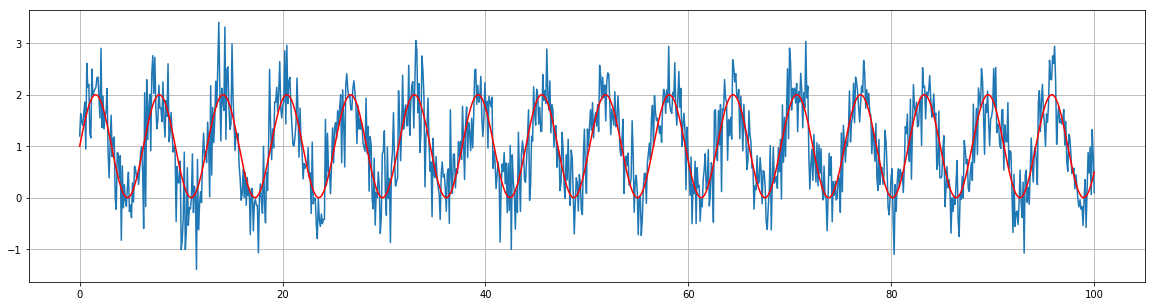

In [3]:
# plot
plt.figure(figsize=(20,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid(True)

In [4]:
def segment(X, length):
    ''' 
    segment a given list of moments to list of chunks each with size length 
    '''
    n_segs = len(X)//length
#     return [X[i+(i+1)*length-op:i+(i+2)*length-op] for i in range(0, n_segs)]
    return [X[i*length:(i+1)*length] for i in range(0, n_segs)]

In [5]:
# split it to train and test
slice_ind = int(n_samples*0.8)
train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 3
# note train_y is actually the value
train_y = np.array(segment(train_y, seq_len))
train_y = train_y.reshape(-1, seq_len, 1)

In [6]:
train_y.shape

(266, 3, 1)

#### So we observe the drift from lstm if it were to generate actual predictions
we employ a different training scheme 

In [7]:
from tensorflow.python.ops.rnn import _transpose_batch_time

def sampling_rnn(cell, initial_state, input_, seq_lengths):    
    # raw_rnn expects time major inputs as TensorArrays
    max_time = seq_len  # this is the max time step per batch
    inputs_ta = tf.TensorArray(dtype=tf.float32, size=max_time, clear_after_read=False)
    inputs_ta = inputs_ta.unstack(_transpose_batch_time(input_))  # model_input is the input placeholder
    input_dim = input_.get_shape()[-1].value  # the dimensionality of the input to each time step
    output_dim = 1  # the dimensionality of the model's output at each time step

    def loop_fn(time, cell_output, cell_state, loop_state):
        """
        Loop function that allows to control input to the rnn cell and manipulate cell outputs.
        :param time: current time step
        :param cell_output: output from previous time step or None if time == 0
        :param cell_state: cell state from previous time step
        :param loop_state: custom loop state to share information between different iterations of this loop fn
        :return: tuple consisting of
          elements_finished: tensor of size [bach_size] which is True for sequences that have reached their end,
            needed because of variable sequence size
          next_input: input to next time step
          next_cell_state: cell state forwarded to next time step
          emit_output: The first return argument of raw_rnn. This is not necessarily the output of the RNN cell,
            but could e.g. be the output of a dense layer attached to the rnn layer.
          next_loop_state: loop state forwarded to the next time step
        """
        if cell_output is None:
            # time == 0, used for initialization before first call to cell
            next_cell_state = initial_state
            # the emit_output in this case tells TF how future emits look
            emit_output = tf.zeros([output_dim])
        else:
            # t > 0, called right after call to cell, i.e. cell_output is the output from time t-1.
            # here you can do whatever ou want with cell_output before assigning it to emit_output.
            # In this case, we don't do anything
            next_cell_state = cell_state
#             emit_output = cell_output 
            
            emit_output = tf.contrib.layers.fully_connected(inputs=cell_output, num_outputs=output_dim)
        
        # check which elements are finished
        elements_finished = (time >= seq_lengths)
        finished = tf.reduce_all(elements_finished)

        # assemble cell input for upcoming time step
        current_output = emit_output if cell_output is not None else None
        input_original = inputs_ta.read(time)  # tensor of shape (None, input_dim)
        if current_output is None:
            # this is the initial step, i.e. there is no output from a previous time step, what we feed here
            # can highly depend on the data. In this case we just assign the actual input in the first time step.
            next_in = input_original
        else:
            # time > 0, so just use previous output as next input
            # here you could do fancier things, whatever you want to do before passing the data into the rnn cell
            # if here you were to pass input_original than you would get the normal behaviour of dynamic_rnn
            next_in = current_output

        next_input = tf.cond(finished,
                             lambda: tf.zeros([batch_size, input_dim], dtype=tf.float32),  # copy through zeros
                             lambda: next_in)  # if not finished, feed the previous output as next input
        # set shape manually, otherwise it is not defined for the last dimensions
        next_input.set_shape([None, input_dim])

        # loop state not used in this example
        next_loop_state = None
        return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)
    outputs_ta, last_state, _ = tf.nn.raw_rnn(cell, loop_fn)
    outputs = _transpose_batch_time(outputs_ta.stack())
    final_state = last_state

    return outputs, final_state


In [14]:
%%time
tf.reset_default_graph()

batch_size = 128
n_batches = train_y.shape[0]//batch_size
state_size = 100


# cell
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)
# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)



# inputs = tf.placeholder(shape=(max_time, batch_size, input_depth),
#                         dtype=tf.float32)

# input 
X = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float32, [batch_size, seq_len, 1])#, name = 'output')

output, last_states = sampling_rnn(cell=lstm_cell, 
                                   initial_state=initial_state, 
                                   input_=X,
                                   seq_lengths=seq_len)

output1 = tf.reshape(output, (batch_size, seq_len, 1))
print('output shape is:', output1.shape)
# pred = tf.contrib.layers.fully_connected(inputs=_transpose_batch_time(output), num_outputs=1)
# pred = tf.contrib.layers.fully_connected(inputs=output, num_outputs=1)
# loss
label = np.roll(train_y, 1) # shift to create next time step
# loss = tf.losses.mean_squared_error(label, tf.reshape(pred, (batch_size, seq_len, 1)))
print('label shape:{0:} | output shape: {1:}'.format(label.shape, output1.shape))

loss = tf.losses.mean_squared_error(label, output1)
# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)

# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
for i in range(1000):
    print(i+1, end='\r')
#     p, l, _ = sess.run([pred, loss, opt], feed_dict={X: train_y})#, Y: label})
    p, l, _ = sess.run([output, loss, opt], feed_dict={X: train_y})#, Y: label})

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Tensor'

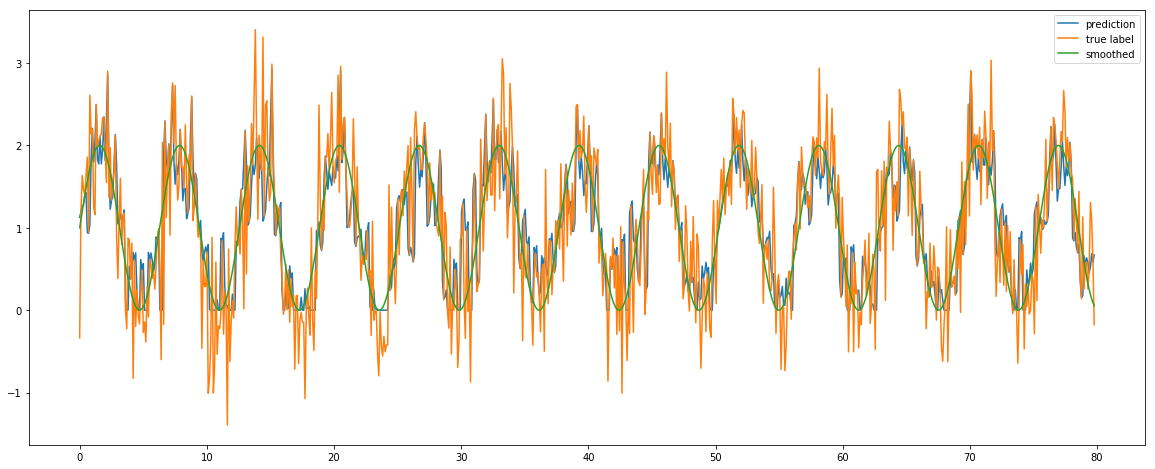

In [9]:
plt.figure(figsize=(20,8))
if seq_len%2 == 0:
    pl = -train_x.shape[0]
else:
    pl = 2
plt.plot(train_x[:-pl], p.reshape(-1), train_x[:-pl], label.reshape(-1), train_x[:-pl], smooth_y_train.reshape(-1)[:-pl])
plt.legend(['prediction', 'true label', 'smoothed'])

#### Test model|

In [10]:
# make test set
test_y = np.array(segment(test_y, seq_len))
test_y = test_y.reshape(-1, seq_len, 1)
test_y.shape

(66, 3, 1)

In [11]:
test_pred = sess.run([output], feed_dict={X: test_y})[0]#, Y: np.roll(test_y,1)})[0]
test_pred = test_pred.reshape(-1)

ValueError: Cannot feed value of shape (66, 3, 1) for Tensor 'Placeholder:0', which has shape '(266, 3, 1)'

---

In [ ]:
# %%time
# tf.reset_default_graph()
# state_size = 100
# lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)

# X = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'input')
# Y = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'output')

# # dynamic rnn
# output, last_states = tf.nn.dynamic_rnn(inputs=X, cell=lstm_cell, dtype=tf.float64)
# print(output.shape)
# pred = tf.contrib.layers.fully_connected(inputs=output, num_outputs=1)

# # loss
# label = np.roll(train_y, 1) # shift to create next time step
# loss = tf.losses.mean_squared_error(label, pred)

# # optimzier
# opt = tf.train.AdamOptimizer().minimize(loss)


# # session
# sess = tf.Session()
# # Initializing the variables
# sess.run(tf.global_variables_initializer())

# # iterate
# for i in range(1000):
#     print(i+1, end='\r')
#     p, l, _ = sess.run([pred, loss, opt], feed_dict={X: train_y, Y: label})